### Using `numpy.lib.stride_tricks.as_strided()` to implement a window function over an `ndarray` 
I recently learned how to use ad-hoc `shape, strides` data to stride over an ndarray in a way that implements a moving window. This is really convenient! (although it's quite **memory-unsafe!**) 

Credit to [https://realpython.com/numpy-array-programming/](https://realpython.com/numpy-array-programming/)

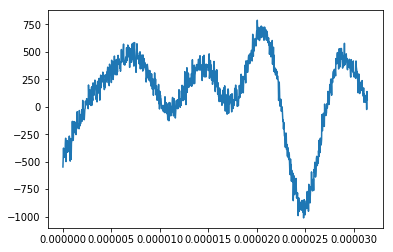

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

Nfreq = 10000
freqlo = 1e3
freqhi = 1000e3
freqs = np.random.uniform(freqlo, freqhi, size=Nfreq)
shifts = np.random.uniform(0, np.pi/2, size=Nfreq)
amps = np.random.uniform(-10, 10, size=Nfreq)
t = np.linspace(0, 5*2*np.pi/freqs.max(), 1000)
SNR = 0.1  # make the signal very noisy
noise = np.random.normal(loc=np.abs(amps).max()/SNR, scale=amps.std()/SNR, size=t.size)
signal = (amps*np.cos(freqs*t[:, np.newaxis] + shifts)).sum(axis=-1) + noise

plt.plot(t, signal)

In [2]:
import numpy.lib.stride_tricks

WWIN = 10  # window width in number of datapoints
strides = 2*signal.strides  # the separation between data will be the same in-memory, we're just striding it two different ways (i.e. we take the same stepsize from one element to another inside of a window)
shape = signal.shape[0] - WWIN + 1, WWIN  # the first value is the number of windows, the second is the width of a window. 
# the offset in the first term prevents us from exceeding the end of the data in our strides, into definitely wrong/possibly invalid memory!

# This call to as_strides() creates a new ndarray object that has the same 
windowed = numpy.lib.stride_tricks.as_strided(signal, shape=shape, strides=strides)
signal.shape, windowed.shape
addrs = [hex(arr.__array_interface__['data'][0]) for arr in (signal, windowed)]
print(f"signal:   ndarray {str(signal.shape):>10} with data at {addrs[0]}, strides {signal.strides}")
print(f"windowed: ndarray {str(windowed.shape):>10} with data at {addrs[1]}, strides {windowed.strides}")

signal:   ndarray    (1000,) with data at 0x29d4bf0, strides (8,)
windowed: ndarray  (991, 10) with data at 0x29d4bf0, strides (8, 8)


In [3]:
windows = [arr.squeeze() for arr in np.split(windowed, windowed.shape[0], axis=0)]
win0 = str(windows[0]).replace('\n', '')
sig0 = str(signal[:WWIN]).replace('\n', '')
print(f"{'win0':>12}: {win0}")
print(f"{f'signal[:{WWIN}]':>12}: {sig0}")
      
print("\nTesting all windows against signal[winnum:winnum+WWIN]:", 
      all(np.array_equal(windows[i], signal[i:i+10]) for i in range(signal.shape[0] - WWIN + 1)),
      sep='\n')

        win0: [-548.77416196 -469.31790217 -376.78803472 -461.56433931 -445.8051757 -458.52532906 -436.76162829 -423.55952122 -334.51219711 -286.62535261]
 signal[:10]: [-548.77416196 -469.31790217 -376.78803472 -461.56433931 -445.8051757 -458.52532906 -436.76162829 -423.55952122 -334.51219711 -286.62535261]

Testing all windows against signal[winnum:winnum+WWIN]:
True


#### We can be very sure that this is generating a _view_ of our data, without duplication 

In [4]:
arr = np.array([1], dtype='int8')
strided = np.lib.stride_tricks.as_strided(arr, shape=(*arr.shape, 2), strides=(*arr.strides, 0))
print(arr, strided)
arr[0] = 5
print(arr, strided)

[1] [[1 1]]
[5] [[5 5]]


#### Interesting side-effect: the `nbytes` property on an `ndarray` created this way is incorrect

In [5]:
print(arr.nbytes, strided.nbytes)  # numpy is telling us that `strided` is two bytes worth of data, but we've already convinced ourself that only one byte is ever being referred to!

1 2


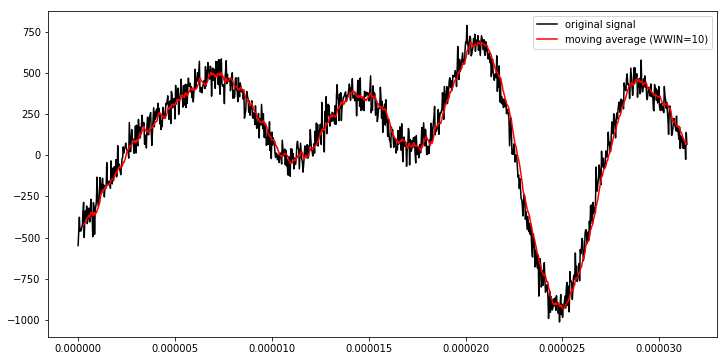

In [6]:
plt.figure(figsize=(12, 6))
moving_avg = np.nanmean(windowed, axis=1)
plt.plot(t, signal, 'k-', label='original signal')
plt.plot(t[WWIN-1:], moving_avg, 'r-', label=f'moving average (WWIN={WWIN})')
plt.legend()

Constructed function gives the same result: True


''

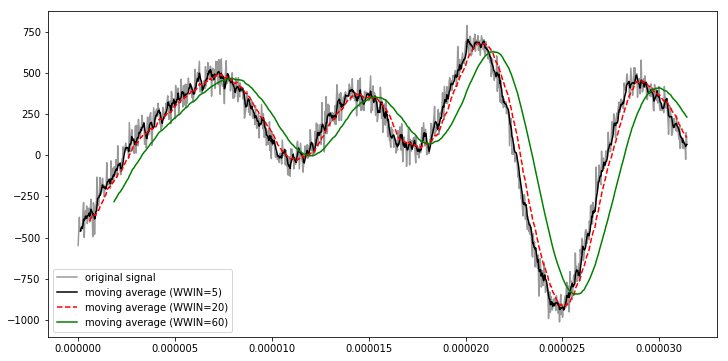

In [7]:
def sliding_window(arr, Wwin):
    """
    Return a view over data in the 1D input `arr`, split into windows of `Wwin` elements apiece
    """
    assert np.ndim(arr) == 1
    assert isinstance(Wwin, int) and Wwin > 0
    return np.lib.stride_tricks.as_strided(arr, strides=2*arr.strides, shape=(arr.shape[0] - Wwin + 1, Wwin))

print(f'Constructed function gives the same result: {np.array_equal(sliding_window(signal, 10), windowed)}')

plt.figure(figsize=(12, 6))
plt.plot(t, signal, '-', color=(0, 0, 0, 0.4), label='original signal')
for wwin, ls in zip((5, 20, 60), ('k-', 'r--', 'g-')):
    mavg = np.nanmean(sliding_window(signal, wwin), axis=1)
    plt.plot(t[wwin-1:], mavg, ls, label=f'moving average (WWIN={wwin})')
    
plt.legend()
;